# Setup

In [4]:
# manipulação de dataset
import pandas as pd

# pacote de álgebra linear, faz manipulações de vetores e etc
import numpy as np

# import pytorch as pyt
from PIL import Image, ImageOps

# functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
import os

# used to return all file paths that match a specific pattern
import glob

# opencv-python, solve computer vision problems
import cv2

# functions to compare files and directories, with various optional time/correctness trade-offs
import filecmp

# split dataset between training and testing data
from sklearn.model_selection import train_test_split

# preprocessing and Normalization, includes scaling, centering, normalization, binarization methods.
from sklearn import preprocessing

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential

from google.colab.patches import cv2_imshow

# Leitura do dataset não processado

In [5]:
groundTruthPath = 'root/GroundTruth.csv'

In [6]:
originalDataset = pd.read_csv(groundTruthPath)
originalDataset.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Transforma onehot encoder em labels qualitativos**

Onehot encoder é uma técnica que transforma valores qualitativos em quantitativos através da geração de conjuntos R^(numero de classes)

In [7]:

labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list=[]

detailedDataset = originalDataset.copy()

for i in range (len(originalDataset)):
    row = list(originalDataset.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
    
detailedDataset['label'] = label_list
detailedDataset = detailedDataset.drop(labels, axis=1)
detailedDataset.head()

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL


# Amostragem dos dados do dataset com as 7 classes de lesões

NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: label, dtype: int64


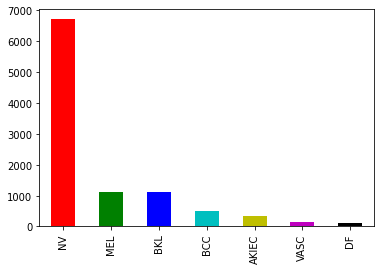

In [8]:
detailedDataset['label'].value_counts().plot.bar(color=['r','g','b','c','y','m','k'])
print(detailedDataset['label'].value_counts())

# Divisão do dataset em meta-classes: benignos e malignos

Estratégia inicial para verificar o resultado do modelo com balancea,emto por subamostragem (undersampling) entre as duas meta-classes


In [9]:
benignLesions = ['NV', 'BKL', 'DF', 'VASC']
malignLesions = ['MEL', 'BCC', 'AKIEC']
benignCode = 'Benigno'
malignCode = 'Maligno'

simplifiedDataset = detailedDataset.copy()

def classifyLesions(row):
  if row['label'] in benignLesions:
    return benignCode
  return malignCode

simplifiedDataset['type'] = simplifiedDataset.apply (lambda row: classifyLesions(row), axis=1)
simplifiedDataset = simplifiedDataset.drop('label', axis=1)
simplifiedDataset.head()

,image,type
0,ISIC_0024306,Benigno
1,ISIC_0024307,Benigno
2,ISIC_0024308,Benigno
3,ISIC_0024309,Benigno
4,ISIC_0024310,Maligno


# Balanceamento

A importância do balanceamento está na etapa de treinamento, entretando ele é realizado com a base inteira antes do treino e teste para não enviesar conjuntos de dados.

Importante deixar cada classe com a quantidade de imagens mais parecida possível.

Nessa abordagem inicial mais simples, queremos somente dividir o data set em duas classes e deixar a mesma quantidade de imagens para cada classe.

In [10]:
print('original number of classes: ', len(detailedDataset['label'].unique()))     

original number of classes:  7


Benigno    8061
Maligno    1954
Name: type, dtype: int64



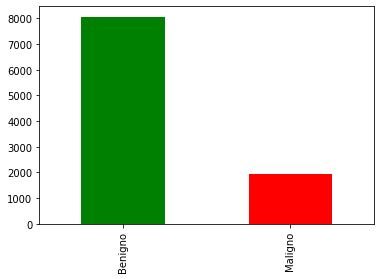

In [11]:
simplifiedDataset['type'].value_counts().plot.bar(color=['g','r'])
print(simplifiedDataset['type'].value_counts())
print()

In [12]:
df = simplifiedDataset;
print(df)

              image     type
0      ISIC_0024306  Benigno
1      ISIC_0024307  Benigno
2      ISIC_0024308  Benigno
3      ISIC_0024309  Benigno
4      ISIC_0024310  Maligno
...             ...      ...
10010  ISIC_0034316  Maligno
10011  ISIC_0034317  Maligno
10012  ISIC_0034318  Benigno
10013  ISIC_0034319  Benigno
10014  ISIC_0034320  Benigno

[10015 rows x 2 columns]


dataset is highly out of balance limit maximum samples per class to 1954 (balanceamento por baixo) samples to help balance it

In [13]:
#size = 1954 # set number of samples for each class
size= 1954 # set number of samples for each class
samples = []

group=df.groupby('type')

for label in df['type'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['type'].value_counts())    
    if count>=size:
        sample=Lgroup.sample(size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 

balanced_df = pd.concat(samples, axis=0).reset_index(drop=True)

print(len(balanced_df))
print('final number of classes: ', len(balanced_df['type'].unique()))       
print(balanced_df['type'].value_counts())  

30
final number of classes:  2
Benigno    15
Maligno    15
Name: type, dtype: int64


# Aplicação de LabelEncoder(type)

Etapa executada antes da divisão de conjuntos para evitar custo computacional ao ter que verificar se os dois conjuntos estão se refereindo a meta classe da mesma forma.

Transformação de:
> Benigno->0

> Maligno-> 1

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [14]:
balanced_df.head()

,image,type
0,ISIC_0030071,Benigno
1,ISIC_0031629,Benigno
2,ISIC_0032931,Benigno
3,ISIC_0029983,Benigno
4,ISIC_0033858,Benigno


In [15]:
le = preprocessing.LabelEncoder()
balanced_df['type']=le.fit_transform(balanced_df['type'])
balanced_df.head()

,image,type
0,ISIC_0030071,0
1,ISIC_0031629,0
2,ISIC_0032931,0
3,ISIC_0029983,0
4,ISIC_0033858,0


# Train Test Split

Essa divisão do dataset está sendo feita após a etapa de balanceamento para prevenir bias (viéses) no treinamento que venham a resultar em um modelo com tendêncidas não generalizadas.
O objetivo do modelo é ser o mais geral possível

Teste será feito com 20% do dataset já balanceado
Treinamento será feito com 80% do dataset já balanceado

In [16]:
test_size = .20 # set this to the percent of the data you want to use for validation
train_size = .80 # set this to the percentof the data you want to use for training

split_df = balanced_df.copy()
train_df, test_df = train_test_split(split_df, test_size = test_size, train_size = train_size, random_state=42, shuffle=True)

In [17]:
print(len(test_df))
test_df.head()

6


,image,type
27,ISIC_0028508,1
15,ISIC_0024875,1
23,ISIC_0032019,1
17,ISIC_0024517,1
8,ISIC_0025494,0


In [18]:
print(len(train_df))
train_df.head()

24


,image,type
28,ISIC_0032985,1
24,ISIC_0024999,1
12,ISIC_0028034,0
0,ISIC_0030071,0
4,ISIC_0033858,0


In [19]:
for data in train_df['image']:
  print(data+'.jpg')

ISIC_0032985.jpg
ISIC_0024999.jpg
ISIC_0028034.jpg
ISIC_0030071.jpg
ISIC_0033858.jpg
ISIC_0033068.jpg
ISIC_0025002.jpg
ISIC_0026294.jpg
ISIC_0033080.jpg
ISIC_0033730.jpg
ISIC_0031629.jpg
ISIC_0032931.jpg
ISIC_0026516.jpg
ISIC_0029983.jpg
ISIC_0033166.jpg
ISIC_0028113.jpg
ISIC_0032424.jpg
ISIC_0033666.jpg
ISIC_0029747.jpg
ISIC_0031628.jpg
ISIC_0025528.jpg
ISIC_0027363.jpg
ISIC_0029570.jpg
ISIC_0030189.jpg


# Obter as imagens do dataset

In [20]:
PATH_CONST = 'root/images/'

all_files = glob.glob(os.path.join(PATH_CONST, "*.jpg"))
print(all_files[1])

root/images/ISIC_0033389.jpg


Aplicar greyscale e reshape nas imagens

In [21]:
print(train_df['image'])

print(type(train_df['image']))

28    ISIC_0032985
24    ISIC_0024999
12    ISIC_0028034
0     ISIC_0030071
4     ISIC_0033858
16    ISIC_0033068
5     ISIC_0025002
13    ISIC_0026294
11    ISIC_0033080
22    ISIC_0033730
1     ISIC_0031629
2     ISIC_0032931
25    ISIC_0026516
3     ISIC_0029983
21    ISIC_0033166
26    ISIC_0028113
18    ISIC_0032424
29    ISIC_0033666
20    ISIC_0029747
7     ISIC_0031628
10    ISIC_0025528
14    ISIC_0027363
19    ISIC_0029570
6     ISIC_0030189
Name: image, dtype: object

In [22]:
X_train = []
X_test = []
for img_name in train_df['image']:
  img = cv2.imread(PATH_CONST + str(img_name)+'.jpg')
  resized_image = cv2.resize(img, (200, 150))
  img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
  
  ph = np.ones((img.shape[0], img.shape[1], 1), dtype='uint8')
  ph[:,:,0] = img
  X_train.append(ph)

for img_name in test_df['image']:
  img = cv2.imread(PATH_CONST + str(img_name)+'.jpg')
  resized_image = cv2.resize(img, (200, 150))
  img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
  
  ph = np.ones((img.shape[0], img.shape[1], 1), dtype='uint8')
  ph[:,:,0] = img
  X_test.append(ph)

In [23]:
#X_train =[np.resize(np.array(cv2.cvtColor(cv2.imread(PATH_CONST + str(img_name)+'.jpg'), cv2.COLOR_BGR2GRAY)),(150,200,3))
#          for img_name in train_df['image']] #greyscale

#X_test = [cv2.imread(PATH_CONST + str(img_name)+ '.jpg') 
#          for img_name in test_df['image']]

In [26]:
# Salvar imagens processadas (redimensionadas e com aplicação de grayscale)

PATH_PROCESSED_CONST = 'root/images/reshape-150_200/'

for img_name, processed_img in zip(train_df['image'], X_train):
  print(PATH_PROCESSED_CONST + str(img_name) + '.jpg')
  cv2.imwrite(PATH_PROCESSED_CONST + str(img_name) + '.jpg',processed_img)
  #processed_img.save(PATH_PROCESSED_CONST + str(img_name) + '.jpg')

root/images/reshape-150_200/ISIC_0032985.jpg
root/images/reshape-150_200/ISIC_0024999.jpg
root/images/reshape-150_200/ISIC_0028034.jpg
root/images/reshape-150_200/ISIC_0030071.jpg
root/images/reshape-150_200/ISIC_0033858.jpg
root/images/reshape-150_200/ISIC_0033068.jpg
root/images/reshape-150_200/ISIC_0025002.jpg
root/images/reshape-150_200/ISIC_0026294.jpg
root/images/reshape-150_200/ISIC_0033080.jpg
root/images/reshape-150_200/ISIC_0033730.jpg
root/images/reshape-150_200/ISIC_0031629.jpg
root/images/reshape-150_200/ISIC_0032931.jpg
root/images/reshape-150_200/ISIC_0026516.jpg
root/images/reshape-150_200/ISIC_0029983.jpg
root/images/reshape-150_200/ISIC_0033166.jpg
root/images/reshape-150_200/ISIC_0028113.jpg
root/images/reshape-150_200/ISIC_0032424.jpg
root/images/reshape-150_200/ISIC_0033666.jpg
root/images/reshape-150_200/ISIC_0029747.jpg
root/images/reshape-150_200/ISIC_0031628.jpg
root/images/reshape-150_200/ISIC_0025528.jpg
root/images/reshape-150_200/ISIC_0027363.jpg
root/image

In [ ]:
cv2_imshow(X_test[0])

In [ ]:
X_train[0].shape

# Criar modelo

Construir uma rede neural CNN levando em conta a dimensão das imagens (450, 600, 3)

https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
height = 450  # image height
width = 600   # image width
channels = -1  # number of color channels, RGB
batch_size = 2  # model batch size for training and evaluation
img_shape = (height, width, channels)
img_size = (height, width)
class_count = 2

Arquitetura EfficientNetB1

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB1

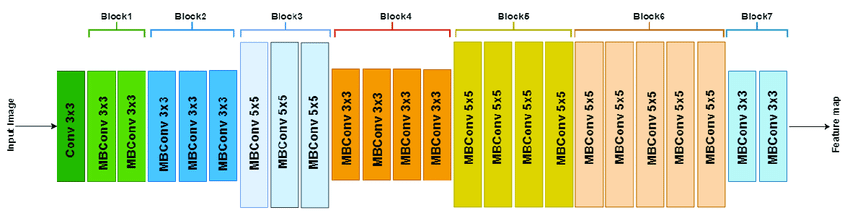

Base de dados imagenet

Utiliza os pesos da EfficientNetB1 treinada na imagenet

In [ ]:
model_name='EfficientNetB5'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=(150, 200,3), pooling='max') 
x=base_model.output

# aplicação de 4 camadas na rede neural

x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

x = Dropout(rate=.45, seed=123)(x)

output=Dense(class_count, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

# Treinar modelo

In [ ]:
X_train = np.array(X_train)
y_train = train_df['type'].to_numpy().reshape(-1)


X_test = np.array(X_test)
y_test = test_df['type'].to_numpy().reshape(-1)

In [ ]:
X_train[0][0]

In [ ]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

# Testar modelo

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# Técnicas de balanceamento para futuros testes

Aplicação de data augumentation, filtro nas imagens, etc
Completar ....

Imagens duplicadas

In [ ]:
# deleta as imagens duplicadas https://www.youtube.com/watch?v=hYkuO-sCPzI
def im_comparator(dataPath: str) -> list:
	count = 0 
	all_files = glob.glob(os.path.join(dataPath, "*.jpg"))
	for file in all_files:
		for pict in all_files:
				if pict != file:
					if filecmp.cmp(file, pict):
						os.remove(pict)
						print(f'similar {file}')
						count+=1
					#else:
						#print('non similar')
	return count

	'''	unique_images = []
		all_files = glob.glob(os.path.join(dataPath, "*.jpg"))
		for count, file_name in enumerate(all_files):
			img = Image.open(file_name)
			# img = list(img.getdata())
			if img not in unique_images:
				unique_images.append(img) 
		
			else:
				print (f'redundant image {count}: {img.filename}')

		return unique_images
	'''

In [ ]:
# imagesPath = r'root/images/sem_duplicadas'

# duplicate_images = im_comparator(imagesPath)

# print(f'duplicate images: {len(duplicate_images)}')

**Data augumentation**

**Aplicar diferentes filtros nas imagens**

In [ ]:
'''imagesPath = r'root/images/filtro'
all_files = glob.glob(os.path.join(imagesPath, "*.jpg"))'''

'''
import cv2
img=cv2.imread("img.jpg")
filter_blur=cv2.blur(img,ksize=(3,3))
cv2.imshow("janela",filter_blur)
cv2.waitKey()
'''

**Rotacionar imagens**

In [ ]:
'''import cv2
import imutils

imagesPath = r'root/images/rotacionada'
all_files = glob.glob(os.path.join(imagesPath, "*.jpg"))

for file in all_files:
  # https://www.askpython.com/python/examples/rotate-an-image-by-an-angle-in-python
  image = cv2.imread(file)
  rot = imutils.rotate(image, angle=45)
  cv2_imshow(rot)
  cv2.waitKey(0)'''